# ALS cfDNA 
reads in CelFiE output run on UCSF and UQ ALS data and plots results 

## Imports and Setup

In [1]:
# python packages 
import pandas as pd
import numpy as np 
import pickle as pkl 
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import os 

In [2]:
# import R to be used in python 
# sorry R people that may be reading this code 
import rpy2
%load_ext rpy2.ipython

In [3]:
os.chdir("/Users/christacaggiano/Desktop/zaitlen_lab_desktop/")

In [4]:
# set white seaborn plotting style 
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

## Functions 

In [5]:
def load_pickles(directory, ref_labels, ind_labels, sex, ethnicity, onset, alsfrs, age, date):
    """ 
    loads each replicate's CelFiE output saved as pickle files 
    """
    pickle_files = glob.glob(directory + "/*alpha.pkl")  # get all CelFiE output 
    pickle_list = []
    for file in pickle_files:  # iterate over the replicates 
        f = open(file, "rb")
        pickle_list.append(pkl.load(f))  # make a list of all outputs for parsing to dataframe
        f.close()
        
    return pickle_to_df(pickle_list, ref_labels, ind_labels, sex, ethnicity, onset, alsfrs, age, date)

In [6]:
def pickle_to_df(pickle_list, ref_labels, ind_labels, sex, ethnicity, onset, alsfrs, age, date):
    """
    take list of pickle files from load_pickles and transform to a dataframe with 
    correct clinical information annotated for each individual 
    """
    
    df = pd.DataFrame(columns={"estimate", "individual", "tissue", "category", "sex", "ethnicity", "onset_site",
                              "ALS-FRS", "age", "date"})

    for pickle in pickle_list:
        for i, individual in enumerate(pickle):
            ind = ind_labels[i]  # label with als/control information 
            for j, estimate in enumerate(individual):  # iterate over tissue information 
                ref = ref_labels[j]
                
                # set category whether a person is ctrl or case 
                category = "ctrl"
                if "als" in ind: 
                    category = "case"
                
                # append to dataframe 
                df = df.append({"estimate":estimate, "individual":ind, "tissue":ref, 
                                "category":category, "sex":sex[i], "ethnicity":ethnicity[i],
                               "onset_site":onset[i], "ALS-FRS":alsfrs[i], "age":age[i], "date":date[i]}, ignore_index=True)

    return df

In [7]:
def add_iteration(num, df): 
    """ 
    add replication information to dataframe 
    num: number of entries per replicate (# of reference tissues X # of individuals)
    df: CelFiE Estimate dataframe 
    """
    
    df["iteration"] = 0  # initialize column 
    for i in range(0, len(df), num): 
        df.iloc[i:i+num, -1] = i//num

## ALS Concentration data

In [23]:
concentration = pd.read_csv("concentration3.csv")  # read concentration information csv

In [24]:
# relabel so things labels are standardized 
concentration["category"] = concentration["category"].replace("ctrl", "control")
concentration["category"] = concentration["category"].replace("als", "ALS") 

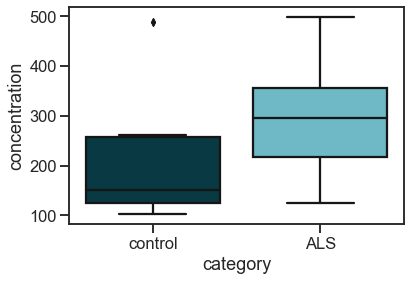

In [25]:
color_palette = sns.color_palette(["#003f4b", "#61c2d3"])
sns.boxplot("category", "concentration", data = concentration, order=["control", "ALS"], palette=color_palette)
plt.show()

## Concentration statistics 

In [11]:
# print standard deviation and mean of concentrations 
print(concentration.groupby("category")["concentration"].std())
print()
print(concentration.groupby("category")["concentration"].mean())

category
ALS        110.572949
control    139.168546
Name: concentration, dtype: float64

category
ALS        297.722083
control    218.783417
Name: concentration, dtype: float64


In [12]:
%%R 
# R code to calculate the p-value between the concentration differences 

df = read.csv("concentration3.csv")  # re-read in the dataframe for this R code 
df$category <- as.character(df$category)
df$category[df$category == "als"] <- 1
df$category[df$category == "ctrl"] <- 0
df$category <- as.numeric(df$category)

summary(glm(category ~ concentration + Sex + Ethnicity, data = df))



Call:
glm(formula = category ~ concentration + Sex + Ethnicity, data = df)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.47004  -0.29077   0.00354   0.27639   0.55283  

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)    -0.052414   0.255729  -0.205  0.84078   
concentration   0.002974   0.000881   3.376  0.00497 **
SexMale        -0.093648   0.206223  -0.454  0.65724   
EthnicityWhite  0.129176   0.193735   0.667  0.51658   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.1559061)

    Null deviance: 3.8824  on 16  degrees of freedom
Residual deviance: 2.0268  on 13  degrees of freedom
  (7 observations deleted due to missingness)
AIC: 22.089

Number of Fisher Scoring iterations: 2



## Read CelFiE data

In [13]:
# reference labels
reference = ["dendritic", "endothelial", "eosinophil", "erythroblast", "macrophage", "memory b", 
            "monocyte", "natural killer",  "neutrophil", "placenta", "t cell cd8", "t cell cd4",
            "adipose", "hepatocyte", "pancreas", "skeletal muscle", "small intestine", 
            "spleen", "stomach", "tibial nerve", "unknown"]

### UCSF data 
discovery cohort

In [14]:
ucsf_labels = ["als10", "als11", "als12", "als13", "als14", "als15", "als16", "ctrl17", 
               "ctrl18", "ctrl19", "ctrl20", "ctrl21", "ctrl22", "ctrl23", "ctrl24", "als9"]

In [15]:
# read in clinical informatino for UCSF patients
ucsf_clinical_info = pd.read_csv("als924_clinical_info.csv")

In [16]:
# transform clinical information into lists for parsing 
ucsf_onset = list(ucsf_clinical_info["onset"].values)  # where symtoms first occured 
ucsf_alsfrs = list(ucsf_clinical_info["ALSFRS"].values)  # functional rating score
ucsf_sex = list(ucsf_clinical_info["sex"].values)
ucsf_ethnicity = list(ucsf_clinical_info["ethnicity_binary"].values)
ucsf_age = list(ucsf_clinical_info["age"].values)
ucsf_date = list(ucsf_clinical_info["date_of_onset"].values)  # date symtoms first occured 

In [17]:
ucsf = load_pickles("als924_tims03_wgbs/", reference, ucsf_labels, ucsf_sex, ucsf_ethnicity, ucsf_onset, ucsf_alsfrs, ucsf_age, ucsf_date)

In [19]:
ucsf

,sex,tissue,individual,age,onset_site,category,ALS-FRS,date,estimate,ethnicity,iteration
0,Male,dendritic,als10,56.654795,limb,case,37.0,566.0,2.067669e-02,white,0
1,Male,endothelial,als10,56.654795,limb,case,37.0,566.0,6.710993e-04,white,0
2,Male,eosinophil,als10,56.654795,limb,case,37.0,566.0,3.595536e-02,white,0
3,Male,erythroblast,als10,56.654795,limb,case,37.0,566.0,4.702994e-02,white,0
4,Male,macrophage,als10,56.654795,limb,case,37.0,566.0,1.435064e-01,white,0
5,Male,memory b,als10,56.654795,limb,case,37.0,566.0,1.005853e-04,white,0
6,Male,monocyte,als10,56.654795,limb,case,37.0,566.0,4.853814e-02,white,0
7,Male,natural killer,als10,56.654795,limb,case,37.0,566.0,4.751623e-04,white,0
8,Male,neutrophil,als10,56.654795,limb,case,37.0,566.0,1.578861e-01,white,0
9,Male,placenta,als10,56.654795,limb,case,37.0,566.0,2.147724e-11,white,0


In [18]:
# add the replicate information and select only the replicate with the highest log likelihood 
# determined on cluster by reporting the highest LL of 10 random restarts, in this case #6
add_iteration(len(ucsf_labels)*len(reference), ucsf)
ucsf_bestrr = ucsf[ucsf.iteration == 2]

In [19]:
# save best RR 
ucsf_bestrr.to_csv("als_924_wgbs_tims03.csv", index=False)

### UQ + UCSF cohort  
validation cohort 

In [20]:
uq_ucsf_labels = ["als1", "als2", "als3", "als4", "ctrl5", "ctrl6", "ctrl7", "ctrl8", "als25", 
             "ctrl26", "als27", "ctrl28", "als29", "ctrl30", "als31", "ctrl32"]

uq_ucsf_clinical_info = pd.read_csv("als18_clinical_info.csv")

In [21]:
uq_ucsf_onset = list(uq_ucsf_clinical_info["onset"].values)  
uq_ucsf_alsfrs = list(uq_ucsf_clinical_info["ALSFRS"].values)  
uq_ucsf_sex = list(uq_ucsf_clinical_info["sex"].values)
uq_ucsf_ethnicity = list(uq_ucsf_clinical_info["ethnicity_binary"].values)
uq_ucsf_age = list(uq_ucsf_clinical_info["age"].values)
uq_ucsf_date = list(uq_ucsf_clinical_info["date_of_onset"].values)  

In [22]:
uq_ucsf = load_pickles("als18oz_tims03_wgbs/", reference, uq_ucsf_labels, uq_ucsf_sex, uq_ucsf_ethnicity, uq_ucsf_onset, uq_ucsf_alsfrs, uq_ucsf_age, uq_ucsf_date)

In [23]:
add_iteration(len(uq_ucsf_labels)*len(reference), uq_ucsf)
uq_ucsf_bestrr = uq_ucsf[uq_ucsf.iteration ==  4]  # best random restart 

In [42]:
uq_ucsf_bestrr[uq_ucsf_bestrr["tissue"]=="skeletal muscle"].groupby("category")["estimate"].std()

category
case    0.021309
ctrl    0.002639
Name: estimate, dtype: float64

In [35]:
uq_ucsf_bestrr[uq_ucsf_bestrr["tissue"]=="unknown"].groupby("category")["estimate"].std()

category
case    0.113078
ctrl    0.091738
Name: estimate, dtype: float64

In [24]:
# save best RR 
uq_ucsf_bestrr.to_csv("als18oz_wgbs_tims03.csv", index=False)

### All UCSF and UQ combined 

In [25]:
# labels for ALS data
all_labels = ["als1", "als10", "als11", "als12", "als13", "als14", "als15", "als16", "ctrl17", 
       "ctrl18", "ctrl19", "als2", "ctrl20", "ctrl21", "ctrl22", "ctrl23", "ctrl24", 
       "als25", "ctrl26", "als27", "ctrl28", "als29", "als3", "ctrl30", "als31", 
       "ctrl32", "als4", "ctrl5", "ctrl6", "ctrl7", "ctrl8", "als9"]

all_clinical_info = pd.read_csv("als_clinical_info_all.csv")

In [26]:
all_onset = list(all_clinical_info["onset"].values)  
all_alsfrs = list(all_clinical_info["ALSFRS"].values)  
all_sex = list(all_clinical_info["sex"].values)
all_ethnicity = list(all_clinical_info["ethnicity_binary"].values)
all_age = list(all_clinical_info["age"].values)
all_date = list(all_clinical_info["date_of_onset"].values)  

In [27]:
# read in celfie estimates 
all_samples = load_pickles("als_124ozall_wgbs_tims03_/", reference, all_labels, all_sex, all_ethnicity, all_onset, all_alsfrs, all_age, all_date)

In [28]:
add_iteration(len(all_labels)*len(reference), all_samples)
all_samples_bestrr = all_samples[all_samples.iteration == 8]  # best random restart 

In [29]:
# save best RR 
all_samples_bestrr.to_csv("als_124ozall_wgbs_tims03.csv", index=False)

## Plot Data 

### UCSF 

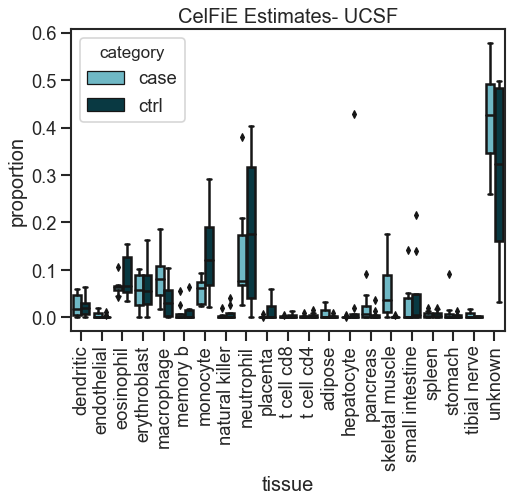

In [30]:
color_palette = sns.color_palette(["#61c2d3", "#003f4b"])
fig=plt.figure(figsize=(7, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.set_context("talk")

g = sns.boxplot("tissue", "estimate", hue="category", data=ucsf_bestrr, palette=color_palette)
plt.ylabel("proportion")
plt.title("CelFiE Estimates- UCSF")
plt.xticks(rotation=90)
plt.show()

### UQ + UCSF

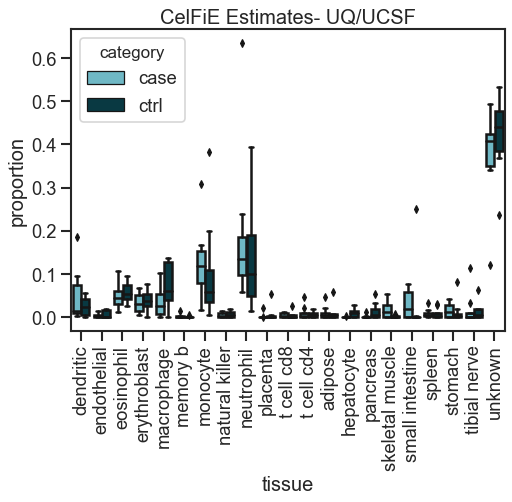

In [31]:
color_palette = sns.color_palette(["#61c2d3", "#003f4b"])
fig=plt.figure(figsize=(7, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.set_context("talk")

g = sns.boxplot("tissue", "estimate", hue="category", data=uq_ucsf_bestrr, palette=color_palette)
plt.ylabel("proportion")
plt.title("CelFiE Estimates- UQ/UCSF")
plt.xticks(rotation=90)
plt.show()

### All

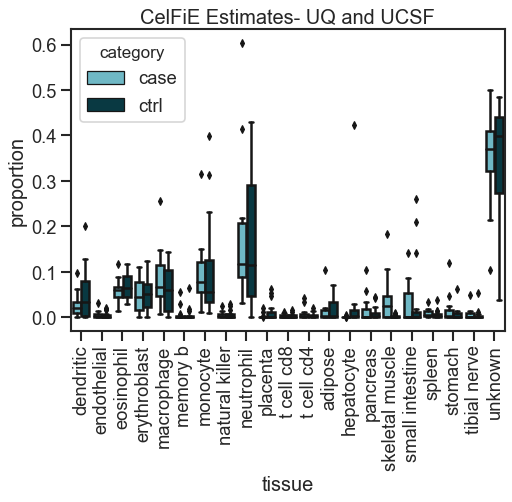

In [32]:
color_palette = sns.color_palette(["#61c2d3", "#003f4b"])
fig=plt.figure(figsize=(7, 5), dpi= 80, facecolor='w', edgecolor='k')
sns.set_context("talk")

g = sns.boxplot("tissue", "estimate", hue="category", data=all_samples_bestrr, palette=color_palette)
plt.ylabel("proportion")
plt.title("CelFiE Estimates- UQ and UCSF")
plt.xticks(rotation=90)
plt.show()

## CelFIE statistics

for paper, we focus on assessing skeletal muscle and tibial nerve 

### UCSF only

In [85]:
# print standard deviation and mean of skeletal muscle estimates 
skeletal_muscle_ucsf = ucsf_bestrr[ucsf_bestrr["tissue"] == "skeletal muscle"]
print(skeletal_muscle_ucsf.groupby("category")["estimate"].std())
print()
print(skeletal_muscle_ucsf.groupby("category")["estimate"].mean())

category
case    0.060221
ctrl    0.001683
Name: estimate, dtype: float64

category
case    0.057548
ctrl    0.000894
Name: estimate, dtype: float64


In [86]:
# print standard deviation and mean of tibial nerve estimates 
tibial_ucsf = ucsf_bestrr[ucsf_bestrr["tissue"] == "tibial nerve"]
print(tibial_ucsf.groupby("category")["estimate"].std())
print()
print(tibial_ucsf.groupby("category")["estimate"].mean())

category
case    0.007031
ctrl    0.001299
Name: estimate, dtype: float64

category
case    0.004922
ctrl    0.000907
Name: estimate, dtype: float64


In [99]:
# print standard deviation and mean of tibial nerve estimates 
unknown_ucsf = ucsf_bestrr[ucsf_bestrr["tissue"] == "unknown"]
print(unknown_ucsf.groupby("category")["estimate"].std())
print()
print(unknown_ucsf.groupby("category")["estimate"].mean())

category
case    0.114625
ctrl    0.190259
Name: estimate, dtype: float64

category
case    0.421831
ctrl    0.299978
Name: estimate, dtype: float64


In [87]:
%%R 
# run statistical analyses in R 
df = read.csv("als_924_wgbs_tims03.csv")  # read in the dataframe saved above to R 

# make data numerical 
df$category <- as.character(df$category)
df$category[df$category == "case"] <- 1
df$category[df$category == "ctrl"] <- 0
df$category <- as.numeric(df$category)

summary(glm(category ~ estimate + sex + ethnicity, data = subset(df, df$tissue=="tibial nerve")))
summary(glm(category ~ estimate + sex + ethnicity, data = subset(df, df$tissue=="skeletal muscle")))


Call:
glm(formula = category ~ estimate + sex + ethnicity, data = subset(df, 
    df$tissue == "skeletal muscle"))

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.54913  -0.26050  -0.00314   0.22484   0.58949  

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)         -0.1067     0.2370  -0.450  0.66136   
estimate             7.1969     2.2195   3.243  0.00784 **
sexMale              0.1272     0.2157   0.590  0.56717   
ethnicitynot white   0.3662     0.2781   1.317  0.21474   
ethnicitywhite       0.5172     0.2755   1.877  0.08724 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.169432)

    Null deviance: 4.0000  on 15  degrees of freedom
Residual deviance: 1.8638  on 11  degrees of freedom
AIC: 23.006

Number of Fisher Scoring iterations: 2



### UQ + UCSF

In [72]:
# print standard deviation and mean of skeletal muscle estimates 
skeletal_muscle_uq_ucsf = uq_ucsf_bestrr[uq_ucsf_bestrr["tissue"] == "skeletal muscle"]
print(skeletal_muscle_uq_ucsf.groupby("category")["estimate"].std())
print()
print(skeletal_muscle_uq_ucsf.groupby("category")["estimate"].mean())

category
case    0.021309
ctrl    0.002639
Name: estimate, dtype: float64

category
case    0.018327
ctrl    0.001727
Name: estimate, dtype: float64


In [73]:
# print standard deviation and mean of tibial nerve estimates 
tibial_uq_ucsf = uq_ucsf_bestrr[uq_ucsf_bestrr["tissue"] == "tibial nerve"]
print(tibial_uq_ucsf.groupby("category")["estimate"].std())
print()
print(tibial_uq_ucsf.groupby("category")["estimate"].mean())

category
case    0.039941
ctrl    0.021694
Name: estimate, dtype: float64

category
case    0.018915
ctrl    0.013984
Name: estimate, dtype: float64


In [74]:
%%R 
# statistical tests for tissue differences 
# skeletal muscle is different, tibial nerve is not 

df = read.csv("als18oz_wgbs_tims03.csv")  # just read in the dataframe saved above to R 

# make data numerical 
df$category <- as.character(df$category)
df$category[df$category == "case"] <- 1
df$category[df$category == "ctrl"] <- 0
df$category <- as.numeric(df$category)

# not with ethnicity since all UQ samples are white 
summary(glm(category ~ estimate + sex, data = subset(df, df$tissue=="tibial nerve")))
summary(glm(category ~ estimate + sex, data = subset(df, df$tissue=="skeletal muscle")))


Call:
glm(formula = category ~ estimate + sex, data = subset(df, df$tissue == 
    "skeletal muscle"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.4453  -0.3855  -0.2313   0.4000   0.7525  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.4154     0.1786   2.326   0.0368 *
estimate     17.8581     8.2749   2.158   0.0502 .
sexMale      -0.1679     0.2744  -0.612   0.5511  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2229375)

    Null deviance: 4.0000  on 15  degrees of freedom
Residual deviance: 2.8982  on 13  degrees of freedom
AIC: 26.07

Number of Fisher Scoring iterations: 2



### All samples

In [76]:
# print standard deviation and mean of skeletal muscle estimates 

skeletal_muscle = all_samples_bestrr[all_samples_bestrr["tissue"] == "skeletal muscle"]
print(skeletal_muscle.groupby("category")["estimate"].std())
print()
print(skeletal_muscle.groupby("category")["estimate"].mean())

category
case    0.049210
ctrl    0.003266
Name: estimate, dtype: float64

category
case    0.038874
ctrl    0.001846
Name: estimate, dtype: float64


In [77]:
# print standard deviation and mean of tibial nerve estimates 

tibial = all_samples_bestrr[all_samples_bestrr["tissue"] == "tibial nerve"]
print(tibial.groupby("category")["estimate"].std())
print()
print(tibial.groupby("category")["estimate"].mean())

category
case    0.012667
ctrl    0.013103
Name: estimate, dtype: float64

category
case    0.005974
ctrl    0.005246
Name: estimate, dtype: float64


In [78]:
%%R 
# statistical tests for tissue differences 
# skeletal muscle is different, tibial nerve is not 

df = read.csv("als_124ozall_wgbs_tims03.csv")  # just read in the dataframe saved above to R 

# make data numerical 
df$category <- as.character(df$category)
df$category[df$category == "case"] <- 1
df$category[df$category == "ctrl"] <- 0
df$category <- as.numeric(df$category)

summary(glm(category ~ estimate + sex + ethnicity, data = subset(df, df$tissue=="tibial nerve")))
summary(glm(category ~ estimate + sex + ethnicity, data = subset(df, df$tissue=="skeletal muscle")))


Call:
glm(formula = category ~ estimate + sex + ethnicity, data = subset(df, 
    df$tissue == "skeletal muscle"))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5991  -0.3667  -0.0298   0.3156   0.7102  

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)   
(Intercept)         0.02939    0.17469   0.168  0.86766   
estimate            6.88813    2.06437   3.337  0.00248 **
sexMale             0.09740    0.15684   0.621  0.53979   
ethnicitynot white  0.31400    0.22203   1.414  0.16872   
ethnicitywhite      0.40634    0.19251   2.111  0.04420 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.1904393)

    Null deviance: 8.0000  on 31  degrees of freedom
Residual deviance: 5.1419  on 27  degrees of freedom
AIC: 44.306

Number of Fisher Scoring iterations: 2



## Plot together 

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [82]:
# change the labels on celfie estimates for plotting 
uq_ucsf_bestrr["category"] = uq_ucsf_bestrr["category"].replace("case", "ALS")
uq_ucsf_bestrr["category"] = uq_ucsf_bestrr["category"].replace("ctrl", "control")

ucsf_bestrr["category"] = ucsf_bestrr["category"].replace("case", "ALS")
ucsf_bestrr["category"] = ucsf_bestrr["category"].replace("ctrl", "control")

all_samples_bestrr["category"] = all_samples_bestrr["category"].replace("case", "ALS")
all_samples_bestrr["category"] = all_samples_bestrr["category"].replace("ctrl", "control")

In [88]:
# change the labels on celfie estimates for plotting 
skeletal_muscle["category"] = skeletal_muscle["category"].replace("case", "ALS")
skeletal_muscle["category"] = skeletal_muscle["category"].replace("ctrl", "control")

skeletal_muscle_uq_ucsf["category"] = skeletal_muscle_uq_ucsf["category"].replace("case", "ALS")
skeletal_muscle_uq_ucsf["category"] = skeletal_muscle_uq_ucsf["category"].replace("ctrl", "control")

skeletal_muscle_ucsf["category"] = skeletal_muscle_ucsf["category"].replace("case", "ALS")
skeletal_muscle_ucsf["category"] = skeletal_muscle_ucsf["category"].replace("ctrl", "control")

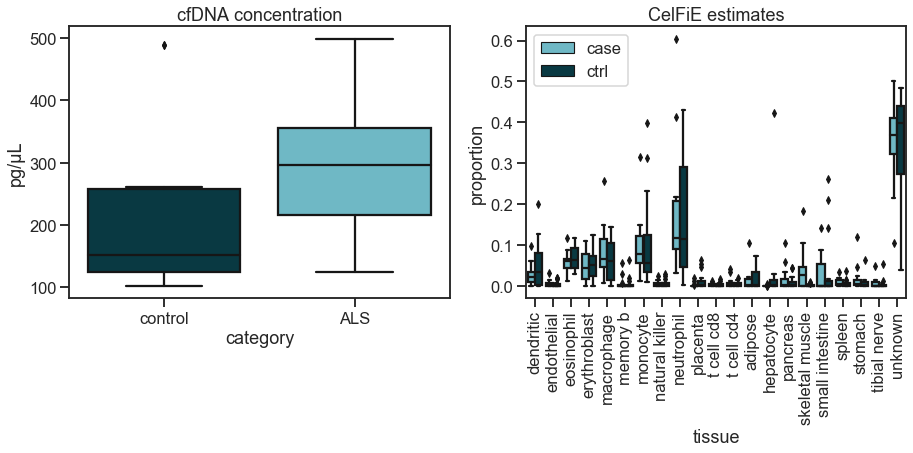

In [95]:
# plot concentration and all estimates 

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.set_context("talk")

color_palette = sns.color_palette(["#003f4b", "#61c2d3"])
sns.boxplot("category", "concentration", data = concentration, order=["control", "ALS"], palette=color_palette, ax=ax1)
ax1.set_title("cfDNA concentration")
ax1.set_ylabel("pg/μL")

color_palette = sns.color_palette(["#61c2d3", "#003f4b"])
sns.boxplot("tissue", "estimate", hue="category", data=all_samples_bestrr, palette=color_palette, ax=ax2)
ax2.set_ylabel("proportion")
ax2.set_title("CelFiE estimates")
ax2.set_xticklabels(labels=reference, rotation=90)

l = ax2.legend()
l.set_title('')

plt.show()

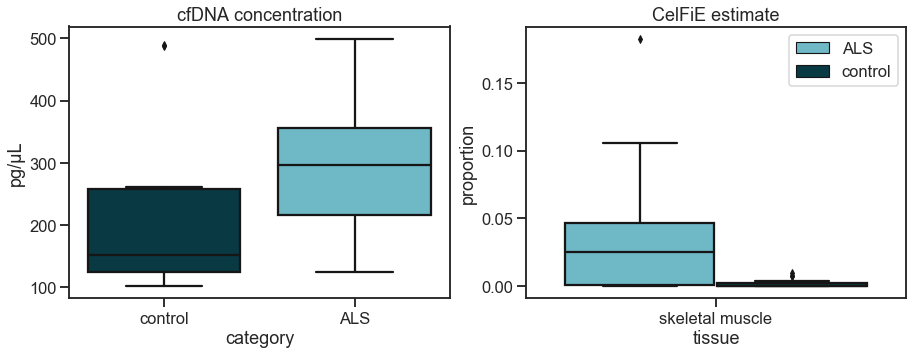

In [96]:
# plot concentration and just skeletal muscle 
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.set_context("talk")

color_palette = sns.color_palette(["#003f4b", "#61c2d3"])
sns.boxplot("category", "concentration", data = concentration, order=["control", "ALS"], palette=color_palette, ax=ax1)
ax1.set_title("cfDNA concentration")
ax1.set_ylabel("pg/μL")

color_palette = sns.color_palette(["#61c2d3", "#003f4b"])
sns.boxplot("tissue", "estimate", hue="category", data=skeletal_muscle, palette=color_palette, ax=ax2)
ax2.set_ylabel("proportion")
ax2.set_title("CelFiE estimate")

l = ax2.legend()
l.set_title('')

plt.show()

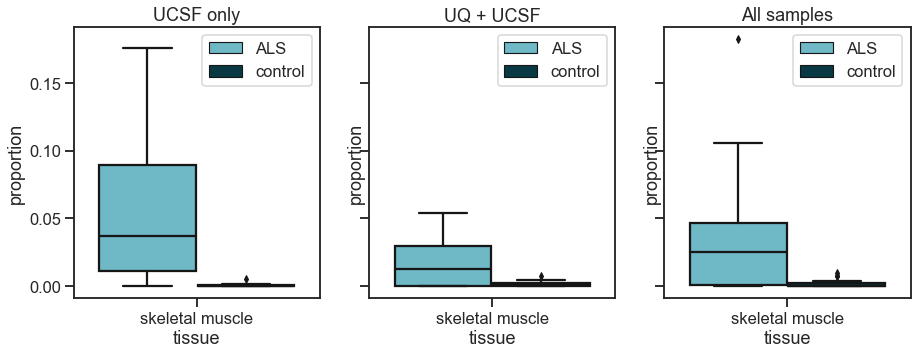

In [98]:
# plot concentration and just skeletal muscle 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(15,5))
sns.set_context("talk")

color_palette = sns.color_palette(["#003f4b", "#61c2d3"])

color_palette = sns.color_palette(["#61c2d3", "#003f4b"])
sns.boxplot("tissue", "estimate", hue="category", data=skeletal_muscle, palette=color_palette, ax=ax3)
ax3.set_ylabel("proportion")
ax3.set_title("All samples")

sns.boxplot("tissue", "estimate", hue="category", data=skeletal_muscle_ucsf, palette=color_palette, ax=ax1)
ax1.set_ylabel("proportion")
ax1.set_title("UCSF only")

sns.boxplot("tissue", "estimate", hue="category", data=skeletal_muscle_uq_ucsf, palette=color_palette, ax=ax2)
ax2.set_ylabel("proportion")
ax2.set_title("UQ + UCSF")

l = ax1.legend()
l.set_title('')

l = ax2.legend()
l.set_title('')

l = ax3.legend()
l.set_title('')

plt.show()

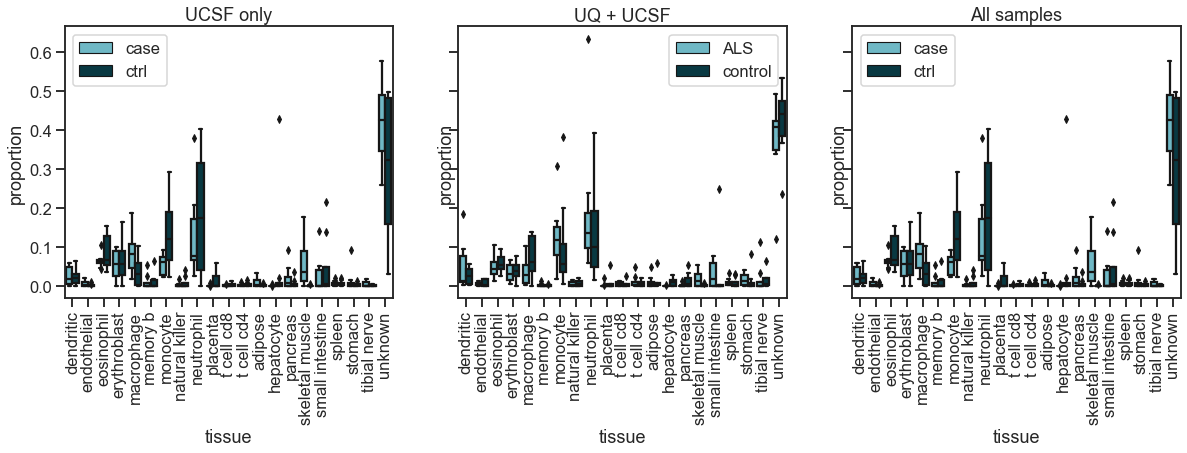

In [101]:
# plot concentration and just skeletal muscle 
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20, 5))
sns.set_context("talk")

color_palette = sns.color_palette(["#003f4b", "#61c2d3"])

color_palette = sns.color_palette(["#61c2d3", "#003f4b"])
sns.boxplot("tissue", "estimate", hue="category", data=ucsf_bestrr, palette=color_palette, ax=ax3)
ax3.set_ylabel("proportion")
ax3.set_title("All samples")

sns.boxplot("tissue", "estimate", hue="category", data=ucsf_bestrr, palette=color_palette, ax=ax1)
ax1.set_ylabel("proportion")
ax1.set_title("UCSF only")

sns.boxplot("tissue", "estimate", hue="category", data=uq_ucsf_bestrr, palette=color_palette, ax=ax2)
ax2.set_ylabel("proportion")
ax2.set_title("UQ + UCSF")

l = ax1.legend()
l.set_title('')
ax1.set_xticklabels(labels=reference, rotation=90)

l = ax2.legend()
l.set_title('')
ax2.set_xticklabels(labels=reference, rotation=90)

l = ax3.legend()
l.set_title('')
ax3.set_xticklabels(labels=reference, rotation=90)

plt.show()